In [14]:
ROI_ANNOTATION_CSV_PATH = "data/2021/anno_origin/roi.csv"
IMAGE_DIR = "data/2021/sample_images"
IMAGE_WITH_ANN_DRAWING_DIR_PATH = "data/2021/sample_annotated_images"

TARGET_IMAGE_NAME = "20211116_151936.jpg"

## 茎葉繁茂度の計算に関するパラメータ（詳細はREADME.mdを参照）
# Extract leaf area
LCH_LOWER = [20.0, 0.0, 0.0]  # For bright area extraction
LCH_UPPER = [100.0, 120.0, 7.0]
HSV_LOWER = [35, 40, 50]  # For green area extraction
HSV_UPPER = [80, 255, 255]

# Visualize leaf density map as heat map
KERNEL_SIZE = 100
DENSITY_MIN = 80
NUM_DENSITY_BINS = 4
DIVIDED_AREA = [0, 30, 170, 240, 255]

# Discritize the image
GRID_SIZE = 6

# 処理対象画像の読み込み

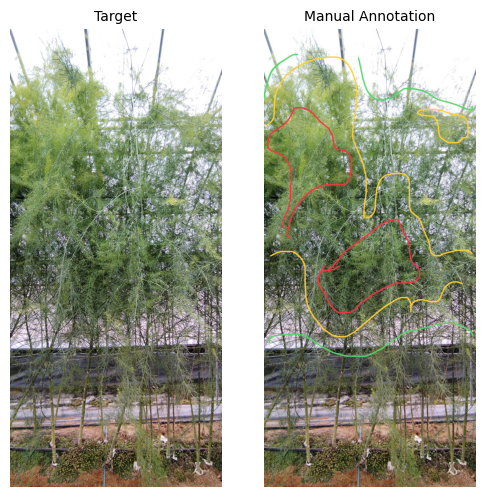

In [15]:
import cv2
from pathlib import Path
from scripts.utils import draw_multiple_image

image_pathlib = Path(IMAGE_DIR) / TARGET_IMAGE_NAME
assert image_pathlib.exists()

image_wi_ann_name = Path(TARGET_IMAGE_NAME).stem + "_anno.jpg"
image_wi_ann_pathlib = Path(IMAGE_WITH_ANN_DRAWING_DIR_PATH) / image_wi_ann_name
assert image_wi_ann_pathlib.exists()

target_image = cv2.imread(str(image_pathlib))
image_wi_ann = cv2.imread(str(image_wi_ann_pathlib))

# 処理対象画像と手動アノテーション画像を並べて表示
draw_multiple_image(["Target", "Manual Annotation"], [target_image, image_wi_ann], figsize=(6, 16))

## 有効領域情報の取得

In [16]:
import csv

map_image_name_to_horizontal_min_max = {}
with open(ROI_ANNOTATION_CSV_PATH) as csvfile:
    annotation_data_list = list(csv.reader(csvfile, delimiter=" ", quotechar="|"))
    for ann_data_icol in annotation_data_list:
        annotaion_info_str_list = ann_data_icol[0].split(",")
        if len(annotaion_info_str_list) == 4:
            image_name = annotaion_info_str_list[0]
            hmin, hmax = int(annotaion_info_str_list[1]), int(annotaion_info_str_list[2])
            map_image_name_to_horizontal_min_max[image_name] = hmin, hmax

assert map_image_name_to_horizontal_min_max.get(TARGET_IMAGE_NAME) is not None

hmin, hmax = map_image_name_to_horizontal_min_max[TARGET_IMAGE_NAME]

print(f"有効領域の画像縦方向の範囲: {hmin, hmax}")

有効領域の画像縦方向の範囲: (100, 2200)


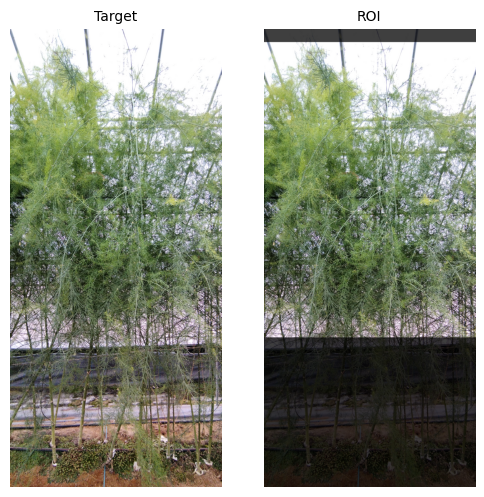

In [17]:
import numpy as np

image_roi_visualized = target_image.copy()
image_roi_visualized = np.clip(image_roi_visualized.astype(float) * 0.25, 0, 255).astype(np.uint8)
image_roi_visualized[hmin:hmax, :, :] = target_image[hmin:hmax, :, :]

draw_multiple_image(["Target", "ROI"], [target_image, image_roi_visualized], figsize=(6, 16))

# 茎葉候補領域マスクの生成

### 画像をCIELab LCh色空間に変換

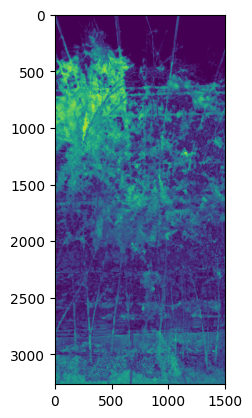

In [18]:
import matplotlib.pyplot as plt
from scripts.leaf_density_index import rgb2lch

image_rgb = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
image_lch = rgb2lch(image_rgb)

image_chroma = image_lch[:, :, 1]
plt.imshow(image_chroma)  # LCh色空間画像の情報例としてChromaチャンネルを表示

### LCh色空間情報を用いて明るめの画像領域のマスク画像（主に背景領域に対応）を生成

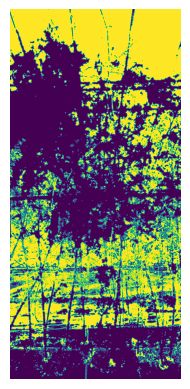

In [19]:
from scripts.utils import show_image_from_ndarray
from scripts.leaf_density_index import extract_bright_area

bright_area_mask = extract_bright_area(image_lch, LCH_LOWER, LCH_UPPER)
show_image_from_ndarray(bright_area_mask)

### HSV色空間情報を用いて緑色の画像領域のマスク画像（主に茎葉領域・前景領域に対応）を生成

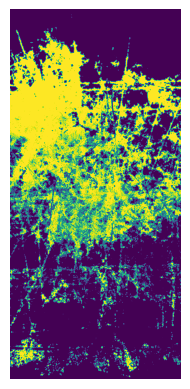

In [20]:
from scripts.leaf_density_index import extract_green_area

green_area_mask = extract_green_area(target_image, HSV_LOWER, HSV_UPPER)
show_image_from_ndarray(green_area_mask)

### 茎葉候補領域マスク画像の抽出
- 先の二種のマスク画像と論理演算を用いて茎葉候補領域マスク画像の抽出を行う
- 画像下領域は例えば地面等が色ベースのマスクセグメンテーション処理の上でノイズ的になるため、先の有効領域選択情報を用いてクロップ処理を行う

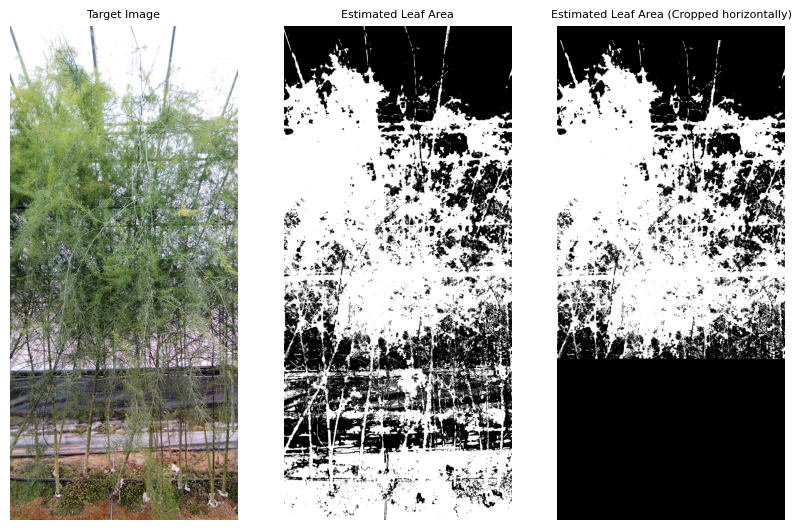

In [21]:
from scripts.utils import draw_multiple_image

leaf_candidate_area_mask = 255 - (bright_area_mask & np.bitwise_not(green_area_mask))

leaf_candidate_area_mask_roi_h_truncated = np.zeros_like(leaf_candidate_area_mask)
leaf_candidate_area_mask_roi_h_truncated[hmin:hmax, :] = leaf_candidate_area_mask[hmin:hmax, :]
leaf_candidate_area_mask_roi_cropped = leaf_candidate_area_mask_roi_h_truncated[hmin:hmax, :]

leaf_candidate_area_mask_3ch = cv2.cvtColor(leaf_candidate_area_mask, cv2.COLOR_GRAY2BGR)
leaf_candidate_area_mask_roi_h_truncated_3ch = cv2.cvtColor(leaf_candidate_area_mask_roi_h_truncated, cv2.COLOR_GRAY2BGR)

draw_multiple_image(
    ["Target Image", "Estimated Leaf Area", "Estimated Leaf Area (Cropped horizontally)"],
    [target_image, leaf_candidate_area_mask_3ch, leaf_candidate_area_mask_roi_h_truncated_3ch],
    figsize=(10, 16),
    title_size=8
)

# 繁茂度マップの作成
- 茎葉候補領域についてマスク画像に対してブラーカーネルを各ピクセルに対して適用することでに局所的な非零ピクセル（上のマスク画像の白領域）の密度値を算出する
- 茎葉候補領域には茎葉以外にもビニールハウスのパイプ等の背景情報も混在しているがマスク面積としては大きくは無い
- 大きめのカーネルサイズのブラーカーネルを適用する事によって茎葉以外物体に対応した非零ピクセルの影響は局所的マスク密度値（=推定繁茂度）の意味で比較的小さくできる

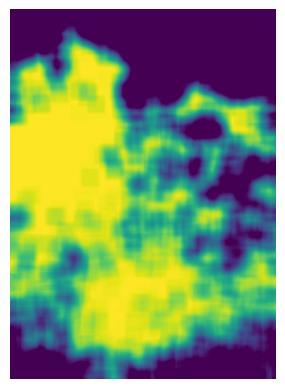

In [22]:
from scripts.leaf_density_index import normalize

density_img = normalize(
    cv2.blur(leaf_candidate_area_mask_roi_cropped, (KERNEL_SIZE, KERNEL_SIZE)), v_min=DENSITY_MIN
)

show_image_from_ndarray(density_img)

# 出力画像の生成

### 繁茂度ヒートマップ画像の生成

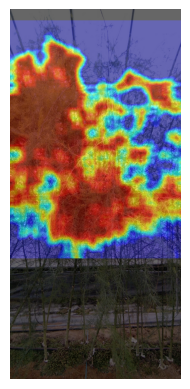

In [23]:
from scripts.utils import alpha_blend
heatmap_img = cv2.applyColorMap(density_img, cv2.COLORMAP_JET)
overlay_heatmap = alpha_blend(target_image, heatmap_img, hmin, hmax)

show_image_from_ndarray(overlay_heatmap)

### 繁茂度ヒートマップ画像を4段階に離散化した画像の生成

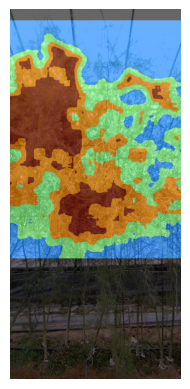

In [24]:
from scripts.leaf_density_index import discretize

# Visualization (contour)
contour_img = cv2.applyColorMap(discretize(density_img), cv2.COLORMAP_JET)
overlay_contour = alpha_blend(target_image, contour_img, hmin, hmax)

show_image_from_ndarray(overlay_contour)

### 繁茂度離散化+グリッド化を行った繁茂度ヒートマップ画像の生成

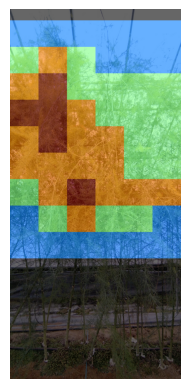

In [25]:
from scripts.leaf_density_index import get_gridview

green_average = get_gridview(leaf_candidate_area_mask_roi_cropped, num_divided_width=GRID_SIZE)
green_average_norm = normalize((1 - green_average) * 255, v_min=DENSITY_MIN)
green_average_digi = discretize(green_average_norm, NUM_DENSITY_BINS, DIVIDED_AREA)
grid_img = cv2.applyColorMap(green_average_digi, cv2.COLORMAP_JET)
overlay_grid = alpha_blend(target_image, grid_img, hmin, hmax)

show_image_from_ndarray(overlay_grid)

### 画像結合
- 以下の順で左から画像を結合する
    - 入力画像
    - 繁茂度ヒートマップ画像
    - 4段階離散化繁茂度マップ画像
    - グリッド化繁茂度マップ画像
    - 農業試験場指導員の方に行って頂いたアノテーション例画像

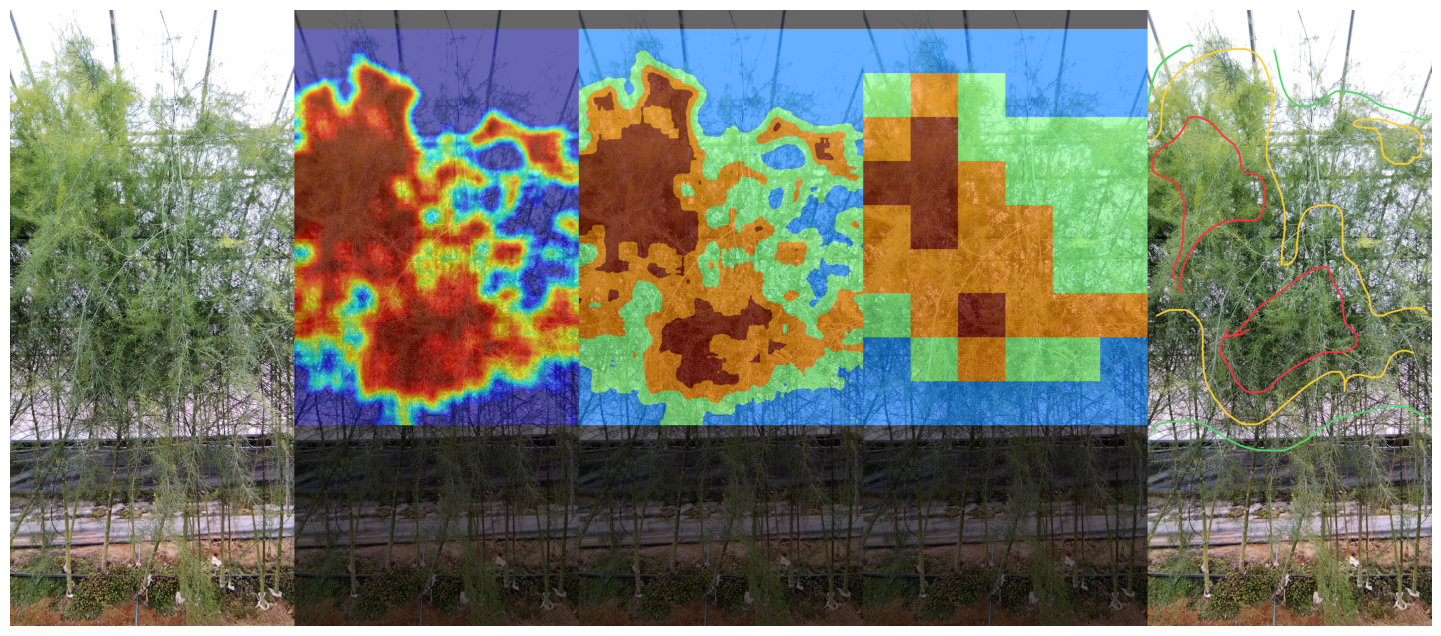

In [26]:
result_concat_image = cv2.hconcat(
    [
        target_image,
        overlay_heatmap,
        overlay_contour,
        overlay_grid,
        image_wi_ann,
    ]
)

show_image_from_ndarray(result_concat_image, figsize=(40, 8))